In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

from arch import arch_model
from filterpy.kalman import KalmanFilter

from fredapi import Fred
import yfinance as yf

### Load Data

In [2]:
load_dotenv()
fred = Fred(api_key=os.getenv("FRED_API_KEY"))

maturities = ["DGS1", "DGS2", "DGS5", "DGS10", "DGS30"] # Yields
yields = pd.DataFrame({mat: fred.get_series(mat) for mat in maturities})
yields = yields.dropna()
yields = yields[yields.index >= pd.Timestamp("2010-01-01")] # Last 15 years of data

### PCA Modeling

In [3]:
pca = PCA(n_components=3)
factors = pca.fit_transform(yields)
factors_df = pd.DataFrame(factors, index=yields.index, columns=["Level", "Slope", "Curvature"])
print("Explained variance ratio:", np.round(pca.explained_variance_ratio_, 4))

Explained variance ratio: [0.8947 0.098  0.0068]


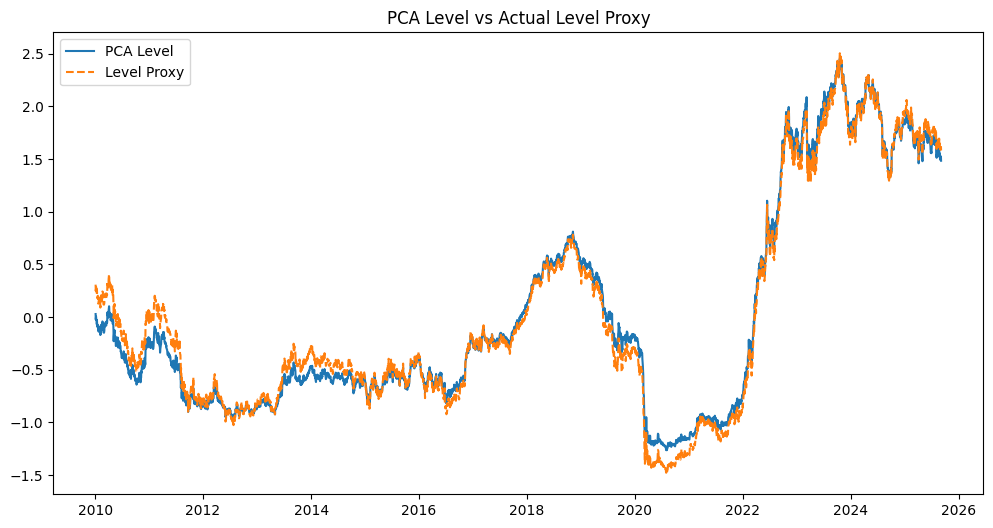

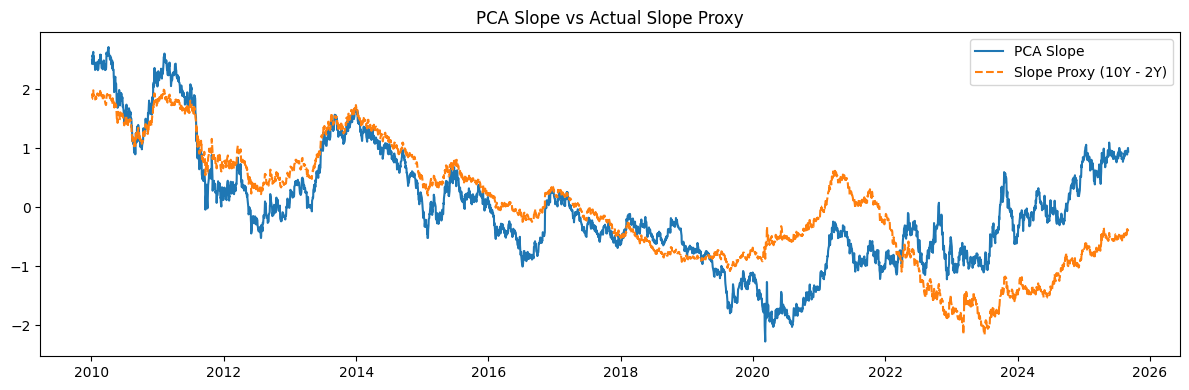

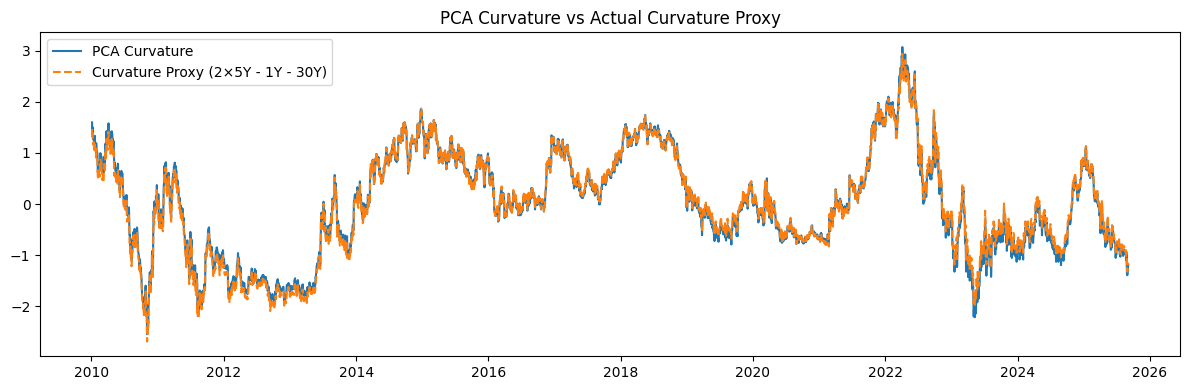

In [4]:
yields["Level_proxy"] = yields.mean(axis=1)
yields["Slope_proxy"] = yields["DGS10"] - yields["DGS2"]
yields["Curvature_proxy"] = 2 * yields["DGS5"] - yields["DGS1"] - yields["DGS30"]

# Normalize for scale comparison
proxies = yields[["Level_proxy", "Slope_proxy", "Curvature_proxy"]]
proxies = (proxies - proxies.mean()) / proxies.std()
pca_factors = (factors_df - factors_df.mean()) / factors_df.std()

# Level Comparison
plt.figure(figsize=(12, 6))
plt.plot(pca_factors["Level"], label="PCA Level")
plt.plot(proxies["Level_proxy"], label="Level Proxy", linestyle="--")
plt.title("PCA Level vs Actual Level Proxy")
plt.legend()
plt.show()

# Slope Comparison
plt.figure(figsize=(12, 4))
plt.plot(pca_factors.index, pca_factors["Slope"], label="PCA Slope")
plt.plot(proxies.index, proxies["Slope_proxy"], label="Slope Proxy (10Y - 2Y)", linestyle="--")
plt.title("PCA Slope vs Actual Slope Proxy")
plt.legend()
plt.tight_layout()
plt.show()

# Curvature Comparison
plt.figure(figsize=(12, 4))
plt.plot(pca_factors.index, pca_factors["Curvature"], label="PCA Curvature")
plt.plot(proxies.index, proxies["Curvature_proxy"], label="Curvature Proxy (2×5Y - 1Y - 30Y)", linestyle="--")
plt.title("PCA Curvature vs Actual Curvature Proxy")
plt.legend()
plt.tight_layout()
plt.show()


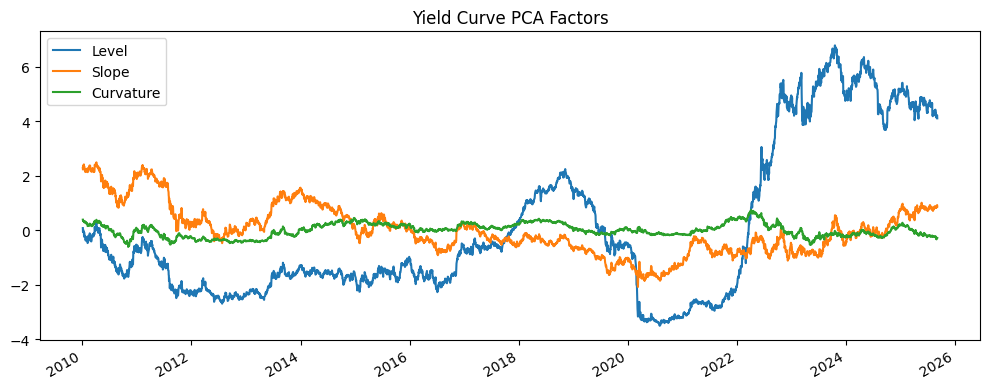

In [5]:
factors_df[["Level", "Slope", "Curvature"]].plot(title="Yield Curve PCA Factors", figsize=(10, 4))
plt.tight_layout()
plt.show()

### Kalman Filter

In [6]:
def apply_kalman_filter(series, window=252):
    smoothed_values = []
    predicted_values = []

    for t in range(len(series)):
        if t < window:
            smoothed_values.append(np.nan)
            predicted_values.append(np.nan)
            continue

        window_data = series.iloc[t - window:t].values
        actual = series.iloc[t]

        kf = KalmanFilter(dim_x=1, dim_z=1)
        kf.x = np.array([window_data[0]])
        kf.F = np.array([[1]])
        kf.H = np.array([[1]])
        kf.P *= 1.0
        kf.R = 0.5
        kf.Q = 0.01

        for z in window_data:
            kf.predict()
            kf.update(z)

        kf.predict()
        predicted_values.append(kf.x[0]) 

        kf.update(actual)
        smoothed_values.append(kf.x[0])

    return pd.Series(smoothed_values, index=series.index), pd.Series(predicted_values, index=series.index)


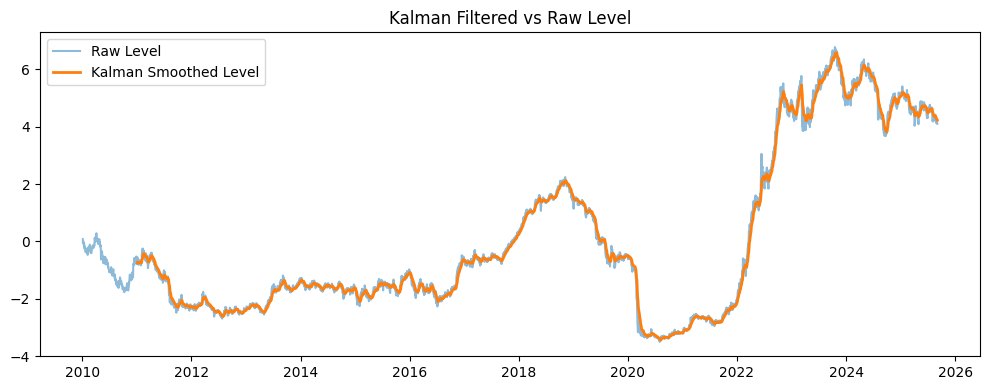

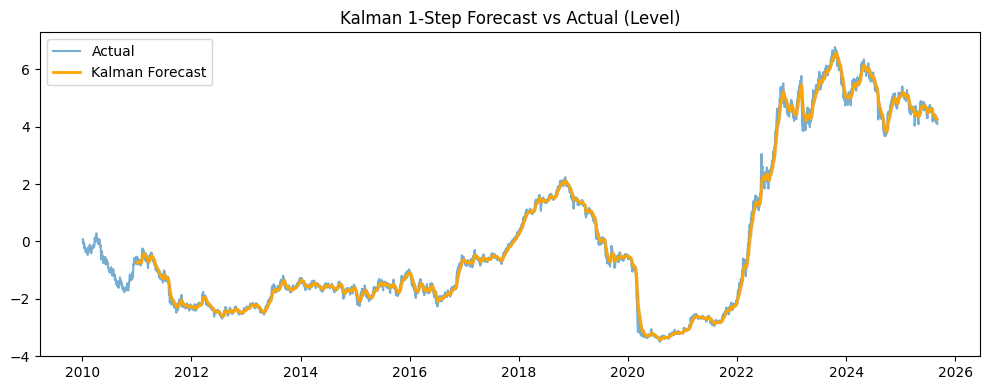

Kalman Forecast Accuracy for Level:
RMSE : 0.176872
MAE  : 0.121565
R^2  : 0.996133


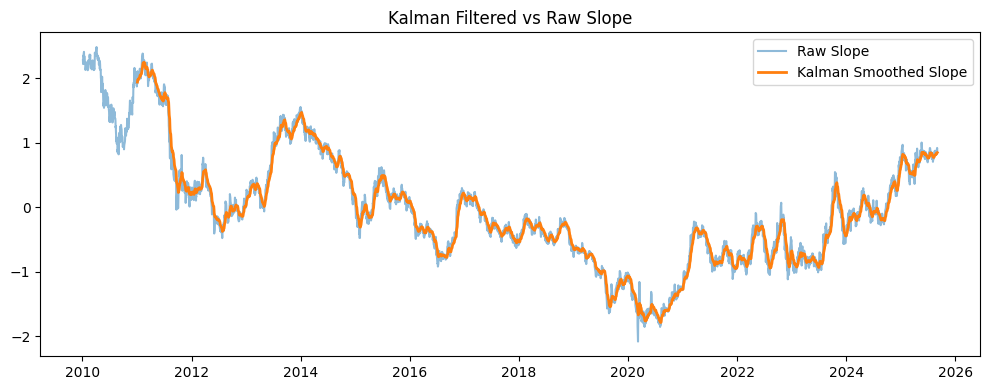

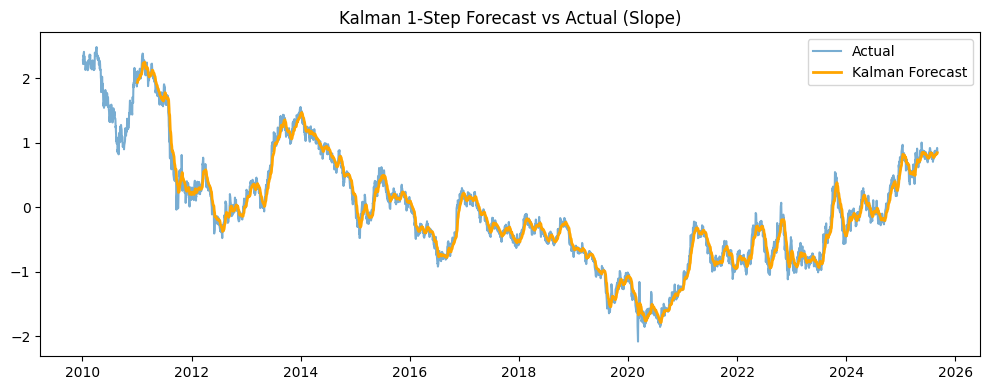

Kalman Forecast Accuracy for Slope:
RMSE : 0.108725
MAE  : 0.082925
R^2  : 0.982092


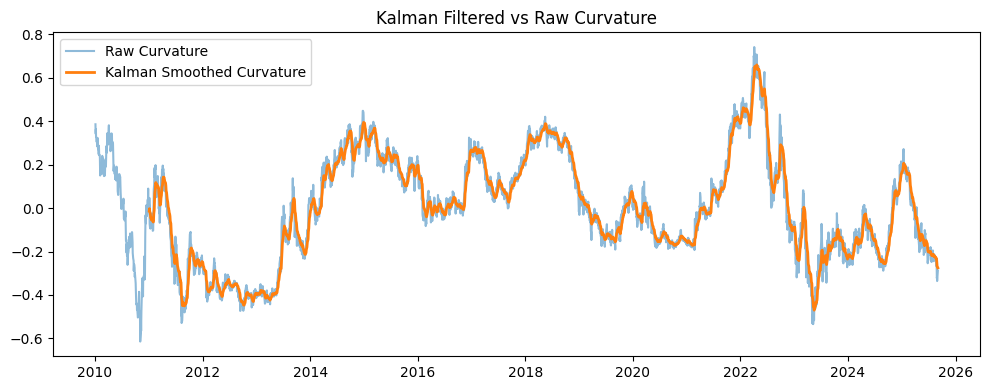

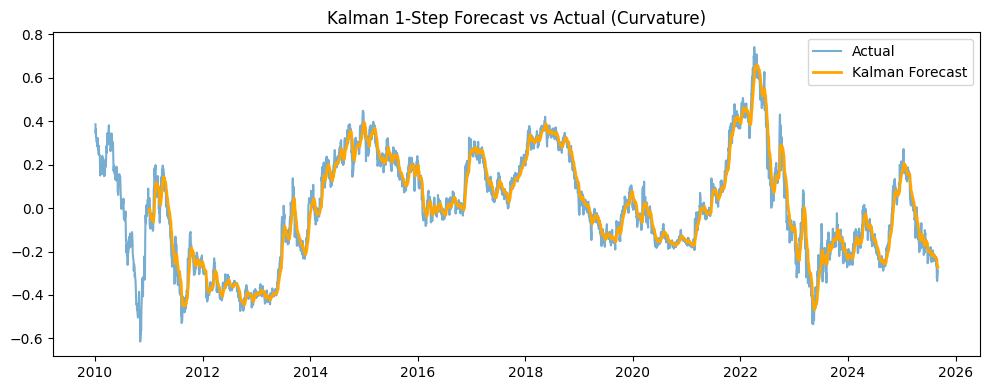

Kalman Forecast Accuracy for Curvature:
RMSE : 0.045662
MAE  : 0.033849
R^2  : 0.963744


In [7]:
for col in ["Level", "Slope", "Curvature"]:
    smoothed, predicted = apply_kalman_filter(factors_df[col])
    factors_df[f"{col}_KF"] = smoothed
    factors_df[f"{col}_KF_Pred"] = predicted

    # Raw vs Smoothed
    plt.figure(figsize=(10, 4))
    plt.plot(factors_df.index, factors_df[col], label=f"Raw {col}", alpha=0.5)
    plt.plot(factors_df.index, factors_df[f"{col}_KF"], label=f"Kalman Smoothed {col}", linewidth=2)
    plt.title(f"Kalman Filtered vs Raw {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Forecast vs Actual
    actuals = factors_df[col]
    forecasts = factors_df[f"{col}_KF_Pred"]
    mask = actuals.notna() & forecasts.notna()

    plt.figure(figsize=(10, 4))
    plt.plot(actuals.index, actuals, label="Actual", alpha=0.6)
    plt.plot(actuals.index, forecasts, label="Kalman Forecast", linewidth=2, color='orange')
    plt.title(f"Kalman 1-Step Forecast vs Actual ({col})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Accuracy Metrics
    rmse = root_mean_squared_error(actuals[mask], forecasts[mask])
    mae = mean_absolute_error(actuals[mask], forecasts[mask])
    r2 = r2_score(actuals[mask], forecasts[mask])

    print(f"Kalman Forecast Accuracy for {col}:")
    print(f"RMSE : {rmse:.6f}")
    print(f"MAE  : {mae:.6f}")
    print(f"R^2  : {r2:.6f}")


### GARCH - SPY Volatility

In [8]:
def garch_forecast(series):
    r = series.pct_change().dropna() * 100.0
    n = len(r)
    train_size = int(n * 0.5)

    pred_vol, actual_vol = [], []
    for i in range(n - train_size):
        train = r.iloc[:train_size + i]
        t_idx = r.index[train_size + i]
        actual_vol.append(np.abs(r.loc[t_idx]))

        try:
            model = arch_model(train, vol="Garch", p=1, q=1, rescale=True)
            res = model.fit(disp="off")
            var_forecast = res.forecast(horizon=1).variance.values[-1, 0]
            pred_vol.append(np.sqrt(var_forecast))
        except Exception:
            pred_vol.append(np.nan)

    idx = r.index[train_size:]
    return pd.Series(pred_vol, index=idx, name="GARCH_vol"), pd.Series(actual_vol, index=idx, name="Realized")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\chuac\Downloads\Macro Risk Analysis\venv\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\chuac\Downloads\Macro Risk Analysis\venv\Lib\site-packages\matplotlib\cbook.py:1355: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


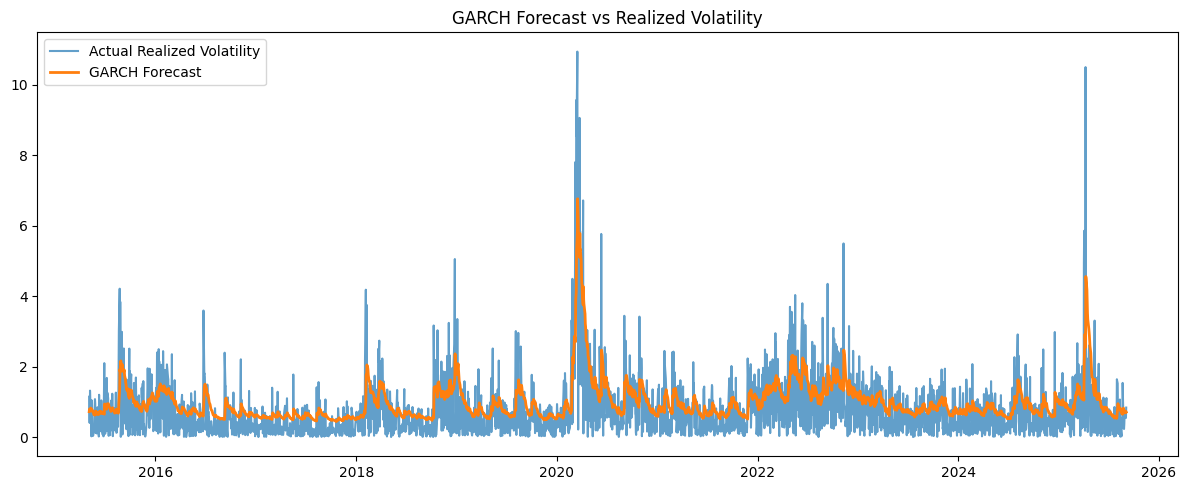

c:\Users\chuac\Downloads\Macro Risk Analysis\venv\Lib\site-packages\sklearn\utils\_array_api.py:746: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
c:\Users\chuac\Downloads\Macro Risk Analysis\venv\Lib\site-packages\sklearn\utils\_array_api.py:746: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
c:\Users\chuac\Downloads\Macro Risk Analysis\venv\Lib\site-packages\sklearn\utils\_array_api.py:746: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


GARCH Forecast vs Realized Volatility Proxy:
R²   : 0.182852
RMSE : 0.785046
MAE  : 0.569745


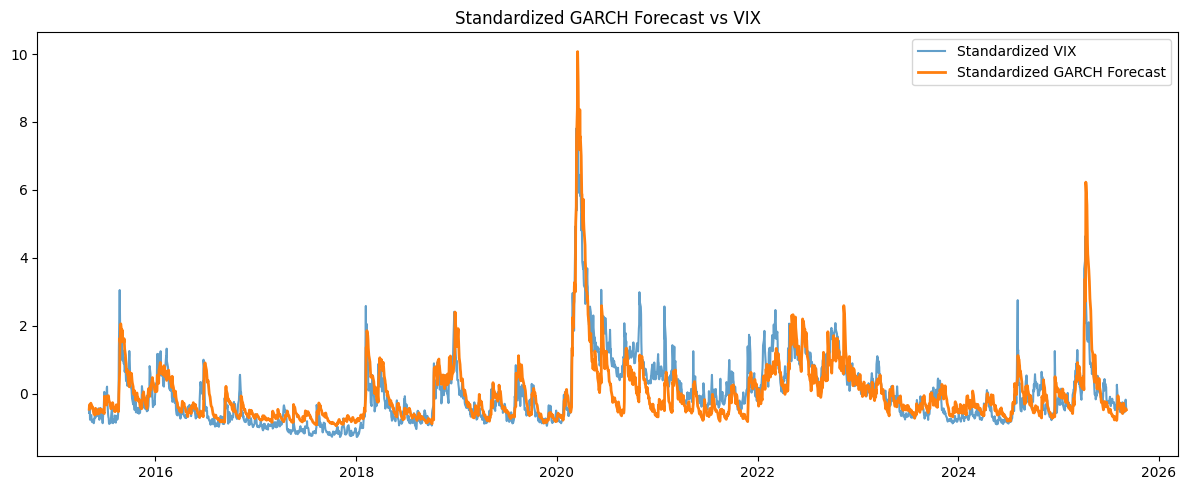

GARCH Forecast vs VIX Accuracy (Standardized):
R²   : 0.698477
RMSE : 0.549111
MAE  : 0.386868


In [9]:
spy = yf.download("SPY", start="2005-01-01", auto_adjust=True)["Close"]
vix = yf.download("^VIX", start="2005-01-01", auto_adjust=True)["Close"]

garch_vol, realized = garch_forecast(spy)
garch_df = garch_vol.to_frame()
realized_df = realized.to_frame()

merged_vol = garch_df.join(realized_df, how="inner").dropna()

plt.figure(figsize=(12, 5))
plt.plot(merged_vol.index, merged_vol["Realized"], label="Actual Realized Volatility", alpha=0.7)
plt.plot(merged_vol.index, merged_vol["GARCH_vol"], label="GARCH Forecast", linewidth=2)
plt.title("GARCH Forecast vs Realized Volatility")
plt.legend()
plt.tight_layout()
plt.show()

r2_realized = r2_score(merged_vol["Realized"], merged_vol["GARCH_vol"])
rmse_realized = root_mean_squared_error(merged_vol["Realized"], merged_vol["GARCH_vol"])
mae = mean_absolute_error(merged_vol["Realized"], merged_vol["GARCH_vol"])
print("GARCH Forecast vs Realized Volatility Proxy:")
print(f"R²   : {r2_realized:.6f}")
print(f"RMSE : {rmse_realized:.6f}")
print(f"MAE  : {mae:.6f}")


merged = garch_df.join(vix, how="inner").dropna()
scaler = StandardScaler()
merged_std = pd.DataFrame(
    scaler.fit_transform(merged),
    index=merged.index,
    columns=merged.columns
)

plt.figure(figsize=(12, 5))
plt.plot(merged_std.index, merged_std["^VIX"], label="Standardized VIX", alpha=0.7)
plt.plot(merged_std.index, merged_std["GARCH_vol"], label="Standardized GARCH Forecast", linewidth=2)
plt.title("Standardized GARCH Forecast vs VIX")
plt.legend()
plt.tight_layout()
plt.show()

r2 = r2_score(merged_std["^VIX"], merged_std["GARCH_vol"])
rmse = root_mean_squared_error(merged_std["^VIX"], merged_std["GARCH_vol"])
mae = mean_absolute_error(merged_std["^VIX"], merged_std["GARCH_vol"])
print("GARCH Forecast vs VIX Accuracy (Standardized):")
print(f"R²   : {r2:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MAE  : {mae:.6f}")


### Strategy

In [10]:
class TreasuryFactorBacktester:
    def __init__(
        self,
        factors_df,
        garch_vol,
        tickers=None,
        kf_suffix="_KF_Pred",
        signal_lookback=63,
        signal_clip=3.0,
        leverage_cap=5.0,
        target_vol=0.10,
        reverse_signals=False
    ):
        self.factors_df = factors_df.copy()
        self.garch_vol = self._prepare_garch_series(garch_vol)
        self.kf_suffix = kf_suffix
        self.signal_lookback = signal_lookback
        self.signal_clip = signal_clip
        self.leverage_cap = leverage_cap
        self.target_vol = target_vol
        self.reverse_signals = reverse_signals

        self.tickers = tickers or {
            "T2Y": "ZT=F", "T5Y": "ZF=F", "T10Y": "ZN=F", "T30Y": "ZB=F"
        }

        self.prices = self._load_futures_prices()
        self.returns = self._compute_percentage_returns()
        self.weights = self._build_factor_weights()

        common_index = self.returns.index.intersection(self.factors_df.index).intersection(self.garch_vol.index)
        self.returns = self.returns.loc[common_index]
        self.factors_df = self.factors_df.loc[common_index]
        self.garch_vol = self.garch_vol.loc[common_index]
        self.weights = self.weights.loc[common_index]

    def _load_futures_prices(self):
        tickers = list(self.tickers.values())
        px = yf.download(tickers, start="2010-01-01", auto_adjust=True)["Close"]
        if isinstance(px.columns, pd.MultiIndex):
            px = px.droplevel(0, axis=1)
        px.columns = [k for k in self.tickers]
        return px.dropna(how="all")

    def _compute_percentage_returns(self):
        return self.prices.pct_change().shift(-1).dropna()

    def _zscore(self, s, win):
        mu = s.rolling(win).mean()
        sd = s.rolling(win).std()
        return (s - mu) / (sd + 1e-9)

    def _prepare_garch_series(self, garch_vol, in_percent=True):
        s = garch_vol.copy()
        if in_percent:
            s = s / 100.0
        return s * np.sqrt(252)

    def _build_factor_weights(self):
        out = pd.DataFrame(0.0, index=self.factors_df.index, columns=[
            "L_T2Y", "L_T5Y", "L_T10Y", "L_T30Y",
            "S_T2Y", "S_T5Y", "S_T10Y", "S_T30Y",
            "C_T2Y", "C_T5Y", "C_T10Y", "C_T30Y"
        ])

        direction = -1 if self.reverse_signals else 1

        sig_L = direction * self._zscore(
            self.factors_df["Level" + self.kf_suffix] - self.factors_df["Level"], self.signal_lookback
        ).clip(-self.signal_clip, self.signal_clip)
        sig_S = direction * self._zscore(
            self.factors_df["Slope" + self.kf_suffix] - self.factors_df["Slope"], self.signal_lookback
        ).clip(-self.signal_clip, self.signal_clip)
        sig_C = direction * self._zscore(
            self.factors_df["Curvature" + self.kf_suffix] - self.factors_df["Curvature"], self.signal_lookback
        ).clip(-self.signal_clip, self.signal_clip)

        out["L_T10Y"] = -sig_L
        out["S_T10Y"] =  sig_S
        out["S_T2Y"]  = -sig_S
        out["C_T5Y"]  =  2.0 * sig_C
        out["C_T2Y"]  = -sig_C
        out["C_T30Y"] = -sig_C

        return out

    def _apply_garch_vol_target(self, daily_ret):
        ann_vol = self.garch_vol.reindex(daily_ret.index).ffill()
        lev = (self.target_vol / ann_vol).clip(upper=self.leverage_cap)
        return daily_ret * lev, lev

    def backtest(self):
        weights = self.weights.reindex(self.returns.index).fillna(0.0)
        r_mat = self.returns[["T2Y", "T5Y", "T10Y", "T30Y"]]

        ret_L = (weights[[f"L_{k}" for k in r_mat.columns]].values * r_mat.values).sum(axis=1)
        ret_S = (weights[[f"S_{k}" for k in r_mat.columns]].values * r_mat.values).sum(axis=1)
        ret_C = (weights[[f"C_{k}" for k in r_mat.columns]].values * r_mat.values).sum(axis=1)

        idx = self.returns.index
        ser_L, ser_S, ser_C = pd.Series(ret_L, index=idx), pd.Series(ret_S, index=idx), pd.Series(ret_C, index=idx)

        vt_L, _ = self._apply_garch_vol_target(ser_L)
        vt_S, _ = self._apply_garch_vol_target(ser_S)
        vt_C, _ = self._apply_garch_vol_target(ser_C)

        combined = (vt_L + vt_S + vt_C) / 3.0
        combined.name = "Combined"

        return pd.concat([
            vt_L.rename("Level"),
            vt_S.rename("Slope"),
            vt_C.rename("Curvature"),
            combined
        ], axis=1)

    def summarize(self, df_ret):
        rows = []
        for col in df_ret.columns:
            r = df_ret[col].dropna()
            eq = (1 + r).cumprod()
            rows.append({
                "strategy": col,
                "ann_return": r.mean() * 252,
                "ann_vol": r.std() * np.sqrt(252),
                "sharpe": r.mean() / r.std() * np.sqrt(252),
                "max_drawdown": self._max_dd(eq)
            })
        return pd.DataFrame(rows).set_index("strategy")

    def _max_dd(self, eq_curve):
        roll_max = eq_curve.cummax()
        dd = eq_curve / roll_max - 1.0
        return dd.min()

    def optimize_and_test(self, split_ratio=0.8):
        idx = self.returns.index
        split = int(len(idx) * split_ratio)
        train_idx, val_idx = idx[:split], idx[split:]

        param_grid = {
            "lookback": [21, 42, 63],
            "clip": [2.0, 2.5, 3.0],
            "vol": [0.08, 0.10, 0.12]
        }

        strategies = ["Level", "Slope", "Curvature", "Combined"]

        for strat in strategies:
            best_result = None
            best_sharpe = -np.inf

            for lookback, clip, vol in itertools.product(*param_grid.values()):
                self.signal_lookback = lookback
                self.signal_clip = clip
                self.target_vol = vol
                self.weights = self._build_factor_weights()
                returns = self.backtest()

                IS = returns.loc[train_idx[0]:train_idx[-1], strat]
                OOS = returns.loc[val_idx[0]:val_idx[-1], strat]

                IS_sharpe = IS.mean() / IS.std() * np.sqrt(252)
                if IS_sharpe > best_sharpe:
                    best_sharpe = IS_sharpe
                    best_result = {
                        "IS_ret": IS,
                        "OOS_ret": OOS,
                        "params": (lookback, clip, vol),
                        "IS_metrics": self.summarize(returns[[strat]].loc[train_idx[0]:train_idx[-1]]),
                        "OOS_metrics": self.summarize(returns[[strat]].loc[val_idx[0]:val_idx[-1]])
                    }

            eq_IS = (1 + best_result["IS_ret"]).cumprod()
            eq_OOS = (1 + best_result["OOS_ret"]).cumprod()

            plt.figure(figsize=(12, 5))
            plt.plot(eq_IS, label="In-Sample")
            plt.plot(eq_OOS, label="Out-of-Sample")
            plt.title(f"Equity Curve - {strat}")
            plt.legend()
            plt.show()

            print(f"\nBest Params for {strat}: lookback={best_result['params'][0]}, clip={best_result['params'][1]}, vol={best_result['params'][2]}")
            print("\nIn-Sample Performance:")
            print(best_result["IS_metrics"])
            print("\nOut-of-Sample Performance:")
            print(best_result["OOS_metrics"])

    def walk_forward_analysis(self, train_window=756, test_window=252):
        idx = self.returns.index
        start = 0
        strategies = ["Level", "Slope", "Curvature", "Combined"]
        walk_forward_returns = {s: [] for s in strategies}

        while start + train_window + test_window < len(idx):
            train_idx = idx[start : start + train_window]
            test_idx = idx[start + train_window : start + train_window + test_window]

            for strat in strategies:
                best_sharpe = -np.inf
                best_ret = None

                for lookback, clip, vol in itertools.product(
                    [21, 42, 63], [2.0, 2.5, 3.0], [0.08, 0.10, 0.12]
                ):
                    self.signal_lookback = lookback
                    self.signal_clip = clip
                    self.target_vol = vol
                    self.weights = self._build_factor_weights()
                    returns = self.backtest()

                    IS = returns.loc[train_idx[0]:train_idx[-1], strat]
                    OOS = returns.loc[test_idx[0]:test_idx[-1], strat]

                    IS_sharpe = IS.mean() / IS.std() * np.sqrt(252)
                    if IS_sharpe > best_sharpe:
                        best_ret = OOS

                walk_forward_returns[strat].append(best_ret)

            start += test_window

        final_returns = {
            k: pd.concat(v) for k, v in walk_forward_returns.items()
        }
        result_df = pd.DataFrame(final_returns)

        plt.figure(figsize=(12, 6))
        for col in result_df.columns:
            eq = (1 + result_df[col]).cumprod()
            plt.plot(eq, label=col)
        plt.title("Walk-Forward Equity Curves by Strategy")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Equity")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print("\nPerformance Summary (Walk-Forward):")
        print(self.summarize(result_df))

        return result_df


[*********************100%***********************]  4 of 4 completed
C:\Users\chuac\AppData\Local\Temp\ipykernel_32644\3619956172.py:46: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return self.prices.pct_change().shift(-1).dropna()


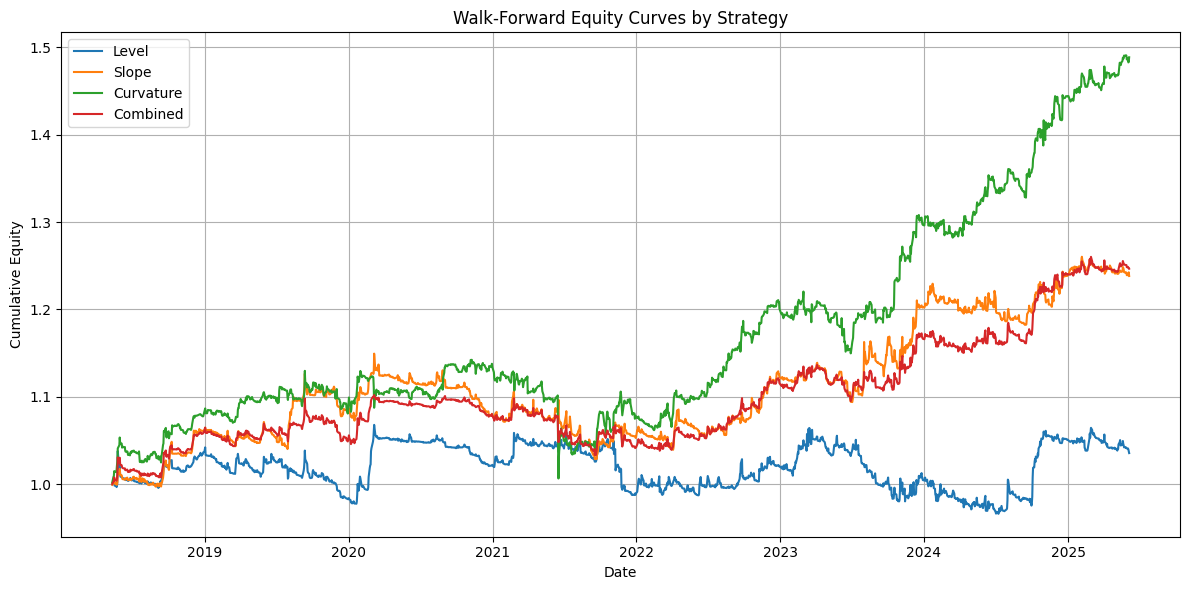


Performance Summary (Walk-Forward):
           ann_return   ann_vol    sharpe  max_drawdown
strategy                                               
Level        0.006603  0.056434  0.116995     -0.095237
Slope        0.032005  0.054287  0.589559     -0.104926
Curvature    0.058755  0.062029  0.947217     -0.118824
Combined     0.032454  0.043860  0.739953     -0.062267


In [11]:
bt = TreasuryFactorBacktester(factors_df, garch_vol, reverse_signals=True)
walk_forward_returns = bt.walk_forward_analysis()